In [1]:
from functools import partial
import logging

import numpy as np
from osgeo import gdal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

In [2]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
img_shape = ds.GetRasterBand(1).ReadAsArray().shape

#ymin = 900
xmin = 100
xmax = 200
ymin = 1000
ymax = 1100



img_shape = (ymax-ymin, xmax-xmin)

shape = (ds.RasterCount, img_shape[0]*img_shape[1])
#shape = (100, img_shape[0]*img_shape[1])
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()[ymin:ymax, xmin:xmax]
    data[bidx] = band.flatten()

In [3]:
def prox_l0_unity(X, step, thresh, axis=0):
    X[X<thresh] = 0
    norm = np.sum(X, axis=axis)
    norm = np.broadcast_to(norm, X.shape)
    bad = norm==0
    X[~bad] = X[~bad]/norm[~bad]
    X[bad] = 0
    return X

def prox_range(X, step, xmin, xmax, axis=0):
    X[X<xmin] =  xmin
    X[X>xmax] = xmax
    return X

In [4]:
obj_count = 5
thresh = .1

# Initialize A0 so that each object has a normalized spectrum
A0 = np.random.rand(shape[0], obj_count)*np.max(data)
# Initialize S0
S0 = np.random.rand(obj_count, img_shape[0]*img_shape[1])
norm = np.sum(S0, axis=0)
S0 = S0/norm
S0[S0<thresh] = 0
norm = np.sum(S0, axis=0)
S0 = S0/norm

#prox_A = proxmin.operators.prox_plus
prox_A = proxmin.proximal.prox_plus
#prox_S = proxmin.operators.prox_unity_plus

# Require at least 10% of the intensity of each object
prox_S = partial(prox_l0_unity, thresh=thresh)
#prox_S = partial(prox_range, xmin=thresh, xmax=1)

In [5]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
b = np.array([[1,1,1]])
b.dot(a)
Ls = [[None], [np.ones((1,S0.shape[0]))]]

def prox_ones(X, step):
    return np.ones_like(X)

#prox_g = [[proxmin.operators.prox_id],[prox_ones]]
prox_g = [[proxmin.proximal.prox_id],[prox_ones]]

In [6]:
Ls[1][0].shape

(1, 5)

In [7]:
#A, S = nmf.nmf(data, A0, S0, prox_A, prox_S, max_iter=300)
#A, S = nmf.nmf(data, A0, S0, prox_A, max_iter=300, l1_thresh=.2, Ls=Ls, proxs_g=prox_g)

In [8]:
def delta_data(A, S, Y, W=1):
    return W*(np.dot(A,S) - Y)

def grad_likelihood_A(A, S, Y, W=1):
    D = delta_data(A, S, Y, W=W)
    return np.dot(D, S.T)

def grad_likelihood_S(S, A, Y, W=1):
    D = delta_data(A, S, Y, W=W)
    return np.dot(A.T, D)

def grad_likelihood(X, allX, xidx, **kwargs):
    if xidx == 0:
        return grad_likelihood_A(X, allX[1], Y=kwargs["data"])
    elif xidx == 1:
        return grad_likelihood_S(X, allX[0], Y=kwargs["data"])
    else:
        raise ValueError("xidx should be zero or 1, got {0}".format(xidx))

prox_fA = partial(proxmin.proximal.prox_likelihood, grad_likelihood=grad_likelihood,
                     data=data, prox_g=proxmin.proximal.prox_plus, xidx=0)
prox_fS = partial(proxmin.proximal.prox_likelihood, grad_likelihood=grad_likelihood,
                     data=data, prox_g=proxmin.proximal.prox_plus, xidx=1)

def prox_ones(X, allX, step, **kwargs):
    return np.ones_like(X)

all_prox_f = [prox_fA, prox_fS]
all_prox_g = [proxmin.proximal.prox_plus, [prox_ones]]

#Ls = [None, [np.ones((1,S0.shape[0]))]]
Ls = [None, [np.ones((1,S0.shape[0]))]]
#all_constraint_norms = [1, np.array([np.linalg.norm(C) for C in Ls[1]])]
all_constraint_norms = [1, np.array([50])]

In [9]:
[A,S], errors, history = proxmin.algorithms.glmm(allX=[A0, S0],
                                                 all_prox_f=all_prox_f,
                                                 all_prox_g=all_prox_g,
                                                 all_constraints=Ls,
                                                 max_iter=200,
                                                 e_rel=1e-2,
                                                 all_constraint_norms=all_constraint_norms,
                                                 traceback=True
                                                )

INFO:proxmin.algorithms:Completed 124 iterations


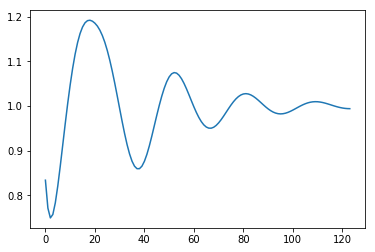

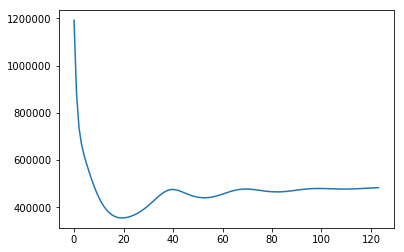

In [10]:
A_hist = [h[0][0] for h in history]
S_hist = [h[0][1] for h in history]
S_sum = [np.sum(sh)/S.shape[1] for sh in S_hist]
plt.plot(S_sum)
plt.show()

A_sum = [np.sum(ah)/A.shape[1] for ah in A_hist]
plt.plot(A_sum)

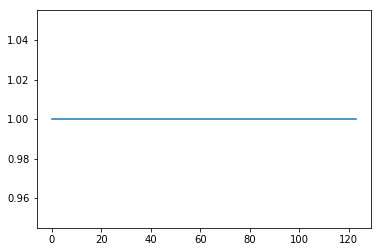

In [11]:
Zk_hist = [h[1][1][0] for h in history]
Zk_sum = [np.sum(zh)/Zk_hist[0].shape[1] for zh in Zk_hist]
plt.plot(Zk_sum)

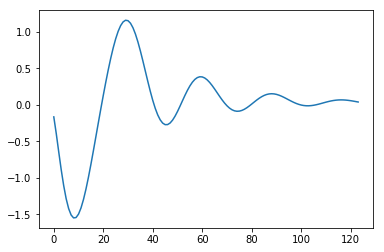

In [12]:
Uk_hist = [h[2][1][0] for h in history]
Uk_sum = [np.sum(uh)/Uk_hist[0].shape[1] for uh in Uk_hist]
plt.plot(Uk_sum)

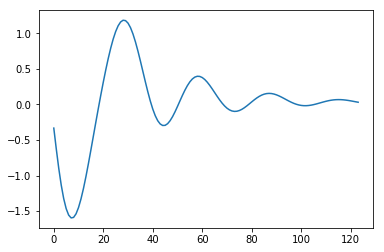

In [13]:
L = Ls[1][0]

CX_hist = [L.dot(s) for s in S_hist]
diff = [CX_hist[n]-Zk_hist[n] for n in range(len(CX_hist))]
diff_sum = [np.sum(dh+Uk_hist[n])/diff[0].shape[1] for n,dh in enumerate(diff)]
plt.plot(diff_sum)

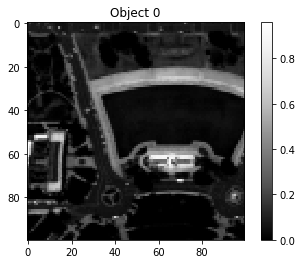

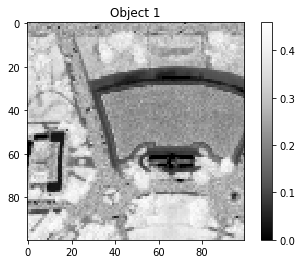

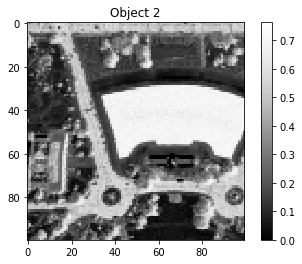

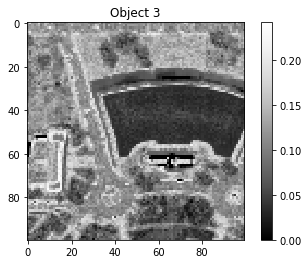

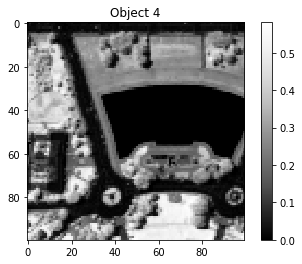

In [14]:
for sidx in range(S.shape[0]):
    plt.imshow(S[sidx].reshape(img_shape), cmap="Greys_r")
    plt.colorbar()
    plt.title("Object {0}".format(sidx))
    plt.show()

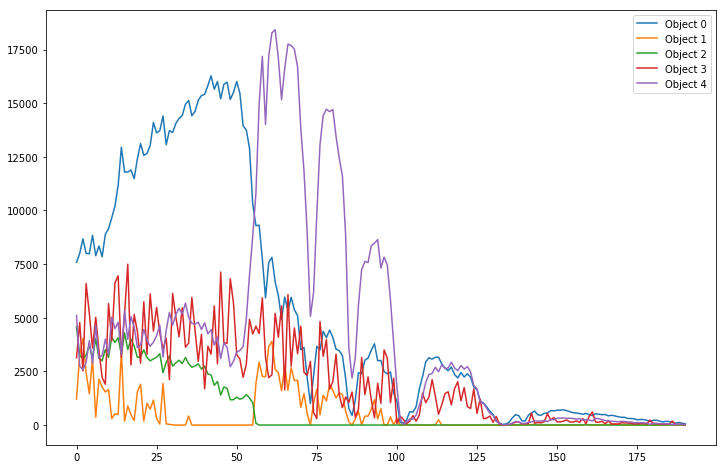

In [15]:
plt.figure(figsize=(12,8))
for row in range(A.shape[1]):
    plt.plot(A[:,row], label="Object {0}".format(row))
plt.legend()
plt.show()

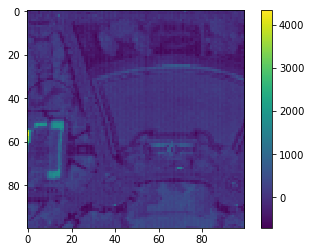

12015.0 0.361173499417


In [23]:
n = 3
model = A.dot(S)
residual = data-model
plt.imshow(residual[n].reshape(img_shape))
plt.colorbar()
plt.show()
print(np.max(data[n]), np.max(residual[n])/np.max(data[n]))